In [2]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp

from pymatching import Matching

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

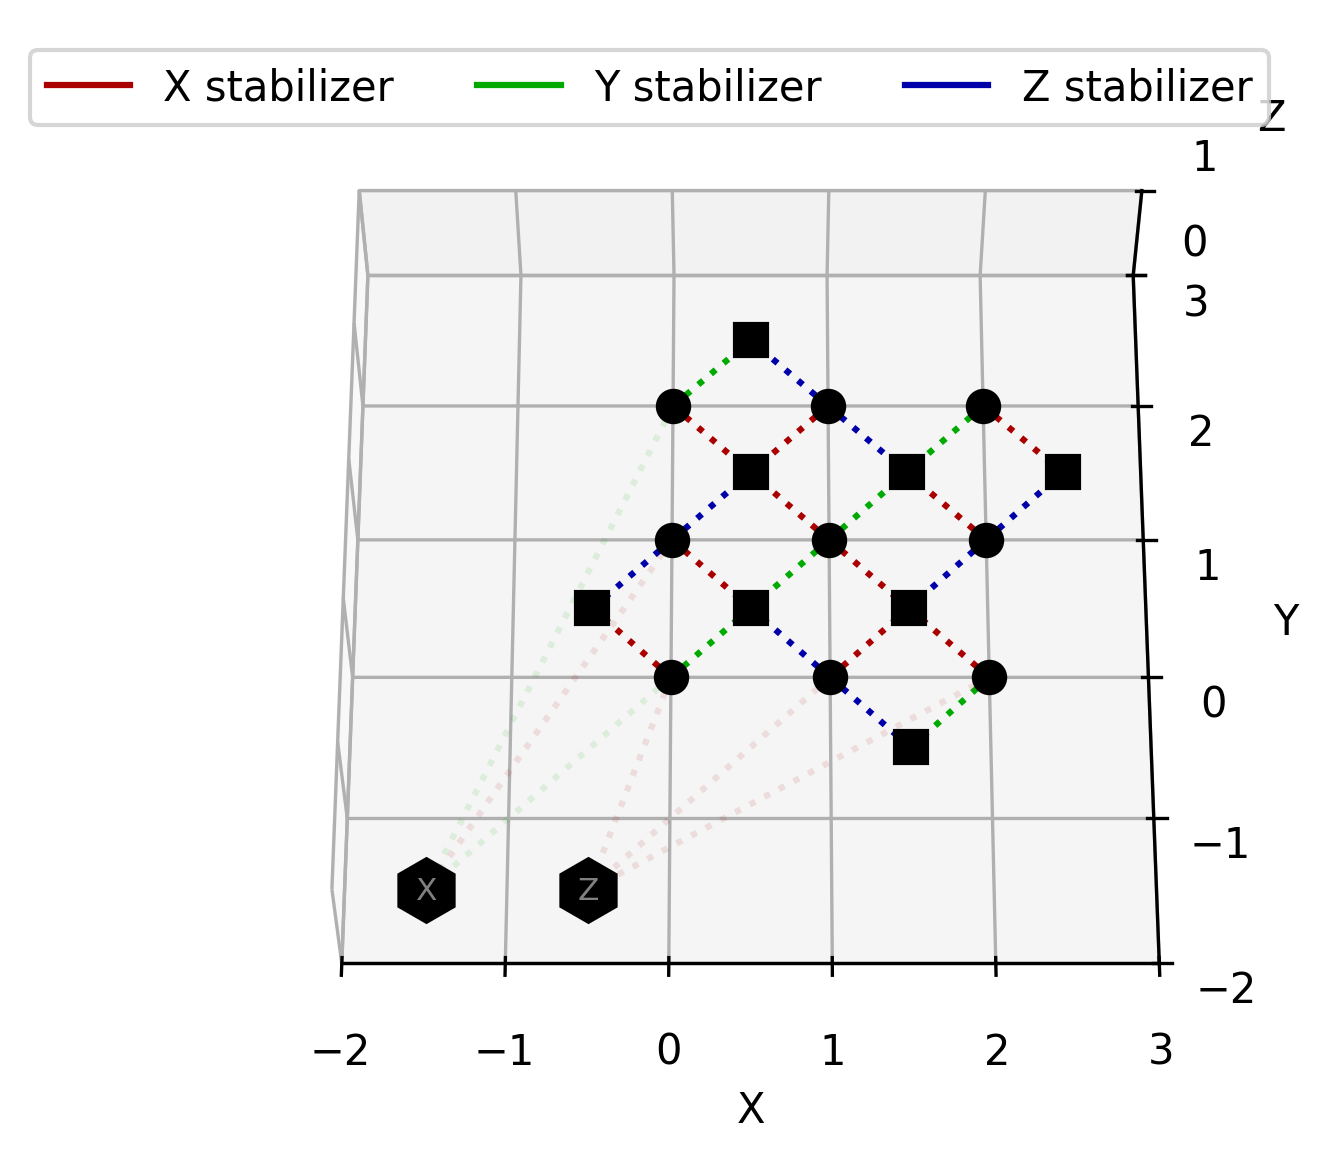

In [3]:
code_distance = 3

qec = QEC(surface_code_data_wls(d=code_distance))
# Loops through the (i,j) coordinates of the data qubits
for i in range(code_distance):
    for j in range(code_distance):
        if (i+j)%2 == 0:
            qec.deform([i,j], deformations['YZ'])
        elif j%2 == 1:
            qec.deform([i,j], deformations['XZ'])
        else:
            qec.deform([i,j], deformations['I'])
qec.show()

In [39]:
def get_data_batch(key, qec: QEC, error_prob: list, batch_size: int = 1) -> tuple[jnp.ndarray]:
    Mx, My, Mz = qec.transformation_matrix()
    errors = jax_create_error_batch(
        px = error_prob[0],
        py = error_prob[1],
        pz = error_prob[2],
        size = Mx.shape[1],
        batch_size = batch_size,
        key = key
    )
    syndromes_ = jax_get_syndromes_batch(Mx, My, Mz, errors)
    syndromes = syndromes_[:,:-2]
    logits = syndromes_[:,-2:]
    return errors, syndromes, logits

def run_mwpm(syndromes, Mx, My, Mz) -> tuple[jnp.ndarray]:
    check_matrix = jnp.append(Mx[:-2,:], Mz[:-2,:], axis=1)
    matching = Matching(check_matrix)
    
    mwpm_recovery = jnp.array([matching.decode(syndrome) for syndrome in syndromes])
    d = mwpm_recovery.shape[1] // 2
    rec_x, rec_z = mwpm_recovery[:,:d], mwpm_recovery[:,d:]
    mwpm_correction = jnp.where(rec_x, jnp.where(rec_z, 2, 1), jnp.where(rec_z, 3, 0))

    mwpm_syndromes_ = jax_get_syndromes_batch(Mx, My, Mz, mwpm_correction)
    mwpm_syndromes = mwpm_syndromes_[:,:-2]
    mwpm_logits = mwpm_syndromes_[:,-2:]
    return mwpm_correction, mwpm_syndromes, mwpm_logits 

def evaluate_MWPM_model(benchmark_data, Mx, My, Mz):
    errors, syndromes, logits = benchmark_data
    # Run the MWPM algorithm
    mwpm_correction, mwpm_syndromes, mwpm_logits = run_mwpm(
        syndromes, Mx, My, Mz
    )
    # Calculate statistics
    mistakes_avg = ((syndromes + mwpm_syndromes) % 2).sum(axis=1).mean()
    logical_error_rate = jnp.not_equal(logits, mwpm_logits).any(axis=1).mean()
    print("Based on the provided benchmark data, the model will:")
    print(f"- on average miss {mistakes_avg:.2f} stabilizers.")
    print(f"- result in a logical error {logical_error_rate:.2%} of the time.")

In [53]:
code_distance = 5

qec = QEC(surface_code_data_wls(d=code_distance))
Mx, My, Mz = qec.transformation_matrix()
# Loops through the (i,j) coordinates of the data qubits
for i in range(code_distance):
    for j in range(code_distance):
        if (i+j)%2 == 0:
            qec.deform([i,j], deformations['YZ'])
        elif j%2 == 1:
            qec.deform([i,j], deformations['XZ'])
        else:
            qec.deform([i,j], deformations['I'])

subkey, key = jax.random.split(key)
benchmark_data = get_data_batch(
    key=subkey, 
    qec=qec, 
    batch_size=10000, 
    error_prob=[.01 for _ in range(3)]
)

errors, syndromes, logits = benchmark_data
mwpm_correction, mwpm_syndromes, mwpm_logits = run_mwpm(syndromes, Mx, My, Mz)

# # Deform the mwpm correction
# mwpm_correction_transformed = []
# for i in range(code_distance):
#     for j in range(code_distance):
#         pauli_in = 'IXYZ'[mwpm_correction[0,i*code_distance+j]]
#         pauli_to_int = {'I':0,'X':1,'Y':2,'Z':3}
#         if (i+j)%2 == 0:
#             mwpm_correction_transformed.append(
#                 pauli_to_int[deformations['YZ'][pauli_in]]
#             )
#         elif j%2 == 1:
#             mwpm_correction_transformed.append(
#                 pauli_to_int[deformations['XZ'][pauli_in]]
#             )
#         else:
#             mwpm_correction_transformed.append(
#                 pauli_to_int[deformations['I'][pauli_in]]
#             )

# # Show the results
# fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': '3d'}, dpi=300)
# fig.set_figwidth(10)
# fig.set_figheight(10)
# qec.show(axis=ax1, errors=errors[0], title="The data")
# qec.show(axis=ax2, errors=jnp.array(mwpm_correction_transformed), title="The MWPM output")
# plt.show()

evaluate_MWPM_model(benchmark_data, Mx, My, Mz)

Based on the provided benchmark data, the model will:
- on average miss 0.00 stabilizers.
- result in a logical error 0.43% of the time.
